<a href="https://colab.research.google.com/github/yunyoung424/Project/blob/main/n312/N312_Assignment_%EC%8B%AC%ED%99%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img align="right" src="https://ds-cs-images.s3.ap-northeast-2.amazonaws.com/Codestates_Fulllogo_Color.png" width=100>

## *AIB / SECTION 3 / SPRINT 1 / NOTE 2*

---

# 📝 Assignment

# 경사하강법과 역전파 알고리즘

## 문제1-1 Sigmoid Classifier 구현하기

오늘 Code Quiz는 간단한 로지스틱 회귀를 통해 오차역전파 과정에 대해 알아보는 것이 목표입니다.

먼저, 데이터셋을 생성해보겠습니다.

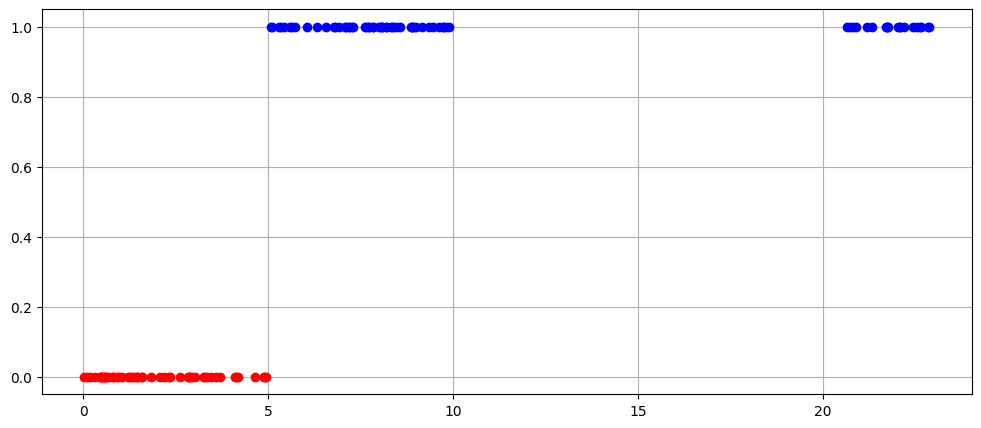

In [1]:
import numpy as np
np.random.seed(0)

x1 = np.random.uniform(low=5, high=10, size=(50,))
x2 = np.random.uniform(low=0, high=5, size=(50,))

y1 = np.ones_like(x1)
y2 = np.zeros_like(x2)

outlier = np.random.uniform(low=20, high=23, size=20)
y_outlier = np.ones_like(outlier)

x1 = np.append(x1, outlier)
y1 = np.append(y1, y_outlier)

x_data = np.hstack([x1, x2])
y_data = np.hstack([y1, y2])

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (12,5))
ax.plot(x_data[:70], y_data[:70], 'bo')
ax.plot(x_data[70:], y_data[70:], 'ro')
ax.grid()

더하기, 빼기, 곱하기 같은 연산을 클래스 단위로 작성해보겠습니다.

plus_node를 예시로 먼저, 설명해드리겠습니다.

plus_node는 순전파(forward)의 경우 2개의 입력값(x,y)를 받고, 이를 더해줍니다.

역전파(backward)시, 앞선 노드들의 역전파 값을 그대로 넘겨주게 됩니다.(```return dz, dz```)

$$D = (x, y)\text{일 때}, \frac{\partial f(x,y)}{\partial D}=[\frac{\partial f(x,y)}{\partial x}, \frac{\partial f(x,y)}{\partial y}] = [1, 1]$$

In [4]:
class plus_node:
    def __init__(self):
        self._x, self._y = None, None
        self._z = None
    
    def forward(self, x, y):
        self._x, self._y = x, y
        self._z = self._x + self._y
        return self._z
    
    def backward(self, dz):
        return dz, dz
    
class minus_node:
    def __init__(self):
        self._x, self._y = None, None
        self._z = None
    
    def forward(self, x, y):
        self._x, self._y = x, y
        self._z = self._x - self._y
        return self._z
    
    def backward(self, dz):
        return dz, -1*dz
    
class mul_node:
    def __init__(self):
        self._x, self._y = None, None
        self._z = None
    
    def forward(self, x, y):
        self._x, self._y = x, y
        self._z = self._x * self._y
        return self._z
    
    def backward(self, dz):
        return dz * self._y, dz * self._x

class square_node:
    def __init__(self):
        self._x = None
        self._z = None
    
    def forward(self, x):
        self._x = x
        self._z = self._x * self._x
        return self._z

    def backward(self, dz):
        return 2 * dz * self._x
    
class mean_node:
    def __init__(self):
        self._x = None
        self._z = None
    
    def forward(self, x):
        self._x = x
        self._z = np.mean(self._x)
        return self._z
    
    def backward(self, dz):
        dx = dz*1/len(self._x)*np.ones_like(self._x)
        return dx

class sigmoid_node():
    def __init__(self):
        self._x, self._y = None, None
        
    def forward(self, x):
        self._x, self._y = x, 1/(1+np.exp(-1*x))
        return self._y
        
    def backward(self, dL):
        return dL * self._y * (1 - self._y)

### 문제 1-1.
다음 보기 중 (mul_node, square_node, sigmoid_node) 역전파 결과물로 올바른 것은?

```
class mul_node:
    def __init__(self):
        self._x, self._y = None, None
        self._z = None
    
    def forward(self, x, y):
        self._x, self._y = x, y
        self._z = self._x * self._y
        return self._z
    
    def backward(self, dz):
        return ### 빈칸 A
```
A = dz * self._y,  dz * self._x

```
class square_node:
    def __init__(self):
        self._x = None
        self._z = None
    
    def forward(self, x):
        self._x = x
        self._z = self._x * self._x
        return self._z

    def backward(self, dz):
        return ### 빈칸 B
```
B = 2 * dz * self._x

```
class sigmoid_node():
    def __init__(self):
        self._x, self._y = None, None
        
    def forward(self, x):
        self._x, self._y = x, 1/(1+np.exp(-1*x))
        return self._y
    def backward(self, dL):
        return ### 빈칸 C
```
C = dL * self._y * (1 - self._y)


다음으로, 노드를 생성하고, 간단한 로지스틱 회귀를 시행해보겠습니다.

여기서 손실함수는 평균 제곱 오차를 수행하겠습니다.

$$ \hat{y} = \theta_1 X + \theta_0  $$
$$ z = Sigmoid(\hat{y}) $$
$$ Loss = (y - z)^2$$
$$ J(Cost) = \frac{\sum_{i=1}^n L_i}{n}$$

In [5]:
mul = mul_node()
plus = plus_node()
sigmoid = sigmoid_node()
minus = minus_node()
square = square_node()
mean = mean_node()

th_list = [0.1, 0.1]
lr = 0.5
epochs = 200000
cost_list = []
th1_list, th0_list = [], []

for i in range(epochs):
    
    Z1 = mul.forward(th_list[1],x_data)
    Z2 = plus.forward(Z1,th_list[0]) 
    Z3 = sigmoid.forward(Z2) 
    Z4 = minus.forward(y_data,Z3) 
    L = square.forward(Z4)
    J = mean.forward(L)
    
    dL = mean.backward(J)
    dZ4 = square.backward(dL)
    dY, dZ3 = minus.backward(dZ4)
    dZ2 = sigmoid.backward(dZ3)
    dZ1, dTheta0 = plus.backward(dZ2)
    dTheta1, dX = mul.backward(dZ1)

    th_list[1] = th_list[1] - lr*np.sum(dTheta1)
    th_list[0] = th_list[0] - lr*np.sum(dTheta0)
    
    cost_list.append(J)
    th1_list.append(th_list[1])
    th0_list.append(th_list[0])

### 문제 1-2

다음 빈칸에 해당하는 순전파 순서로 옳은 것을 고르시오


```
for i in range(epochs):
    ### 빈칸 D
        
    dL = mean.backward(J)
    dZ4 = square.backward(dL)
    dY, dZ3 = minus.backward(dZ4)
    dZ2 = sigmoid.backward(dZ3)
    dZ1, dTheta0 = plus.backward(dZ2)
    dTheta1, dX = mul.backward(dZ1)

    th_list[1] = th_list[1] - lr*np.sum(dTheta1)
    th_list[0] = th_list[0] - lr*np.sum(dTheta0)
    
    cost_list.append(J)
    th1_list.append(th_list[1])
    th0_list.append(th_list[0])
```

답 : 빈칸 D = 

```
Z1 = mul.forward(th_list[1],x_data)
Z2 = plus.forward(Z1,th_list[0]) 
Z3 = sigmoid.forward(Z2) 
Z4 = minus.forward(y_data,Z3) 
L = square.forward(Z4)
J = mean.forward(L)
```

학습한 $\theta_1$과 $\theta_0$를 이용해 시각화해보겠습니다.

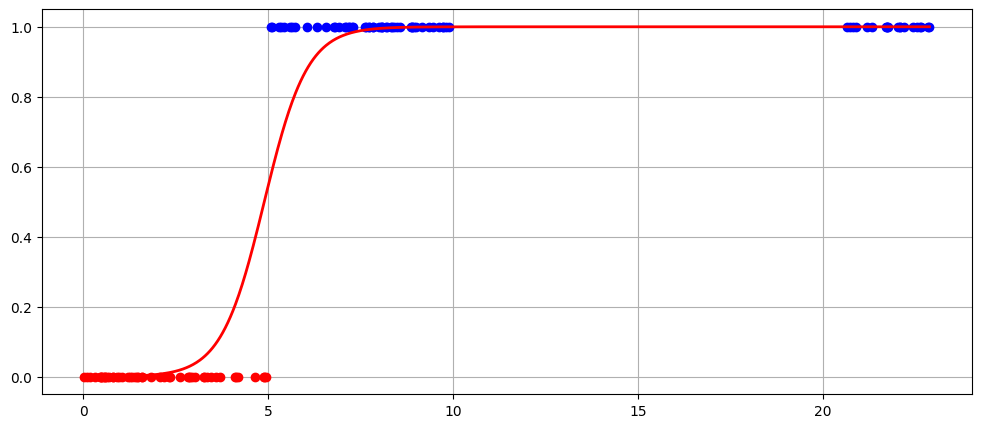

In [6]:
x_min, x_max = x_data.min(), x_data.max()
y_min, y_max = sigmoid.forward(x_min*th_list[1] + th_list[0]), sigmoid.forward(x_max*th_list[1] + th_list[0])
x_range = np.linspace(x_min, x_max, 1000)
y_range = sigmoid.forward(x_range*th_list[1] + th_list[0])

fig, ax = plt.subplots(figsize = (12,5))
ax.plot(x_data[:70], y_data[:70], 'bo')
ax.plot(x_data[70:], y_data[70:], 'ro')
ax.plot(x_range, y_range, 'r', linewidth = 2)
ax.grid()